In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [2]:
#Input Working directory or directory you want to work in
dirname=input("Enter the current working directory")
os.chdir(dirname)# Set current working directory
os.getcwd() # Get current working directory

Enter the current working directory/Users/shivamgoel/Desktop/Python/final


'/Users/shivamgoel/Desktop/Python/final'

In [3]:
airlines_data = pd.read_csv('data/airlines.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
airports_data = pd.read_csv('data/airports.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
flights = pd.read_csv('data/flights.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True,
                           na_values=['NA      ', 'NA    ', 'NA   ', 'NA', 'NA ', 'NA ', 'NaN', 'NAN', ''])

In [4]:
#Shapping Data
airlines_data.shape[0] #no of rows=14
airlines_data.shape[1] #no of columns=2

airports_data.shape[0] #no of rows=322
airports_data.shape[1] #no of columns=7

flights.shape[0] #no of rows = 5819079
flights.shape[1] #no of columns = 31
airports_data.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
unique_flights_data = {}
for item in flights.columns:
    unique_flights_data[item] = flights[item].unique()
#unique_flights_data

In [6]:
day_of_week_desc={
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday',
    7:'Sunday'
}
flights['DESC_DOW']=flights['DAY_OF_WEEK'].apply(lambda a:day_of_week_desc[a])


In [7]:
airlines_dict = dict(zip(airlines_data['IATA_CODE'],airlines_data['AIRLINE']))
airport_dict = dict(zip(airports_data['IATA_CODE'],airports_data['AIRPORT']))
flights['DESC_AIRLINE'] = flights['AIRLINE'].apply(lambda x: airlines_dict[x])
flights.head()['DESC_AIRLINE']

0      Alaska Airlines Inc.
1    American Airlines Inc.
2           US Airways Inc.
3    American Airlines Inc.
4      Alaska Airlines Inc.
Name: DESC_AIRLINE, dtype: object

# Which Airport is best?

# The factors affecting the rank of airports are following:
* Highest Ratio of (Operated flights)/(Scheduled flights)
* Number of flight delays
* Air traffic
* Traffic In and Out time

*Let's calculate the ratio of Operated flights and Scheduled flights first*

In [35]:
flights = flights[flights.ORIGIN_AIRPORT.str.len() == 3]
flights['DESC_OA']=flights['ORIGIN_AIRPORT'].apply(lambda x:airport_dict[x])
flights['DESC_DA']=flights['DESTINATION_AIRPORT'].apply(lambda x:airport_dict[x])
rank_airport = pd.DataFrame(flights.groupby('DESC_OA')['SCHEDULED_DEPARTURE'].count())
rank_airport['CANCELLED']=flights.groupby('DESC_OA')['CANCELLED'].sum()
rank_airport['OPERATED']=rank_airport['SCHEDULED_DEPARTURE']-rank_airport['CANCELLED']
rank_airport['RATIO_OP_SCH']=rank_airport['OPERATED']/rank_airport['SCHEDULED_DEPARTURE']
rank_airport.drop(rank_airport.columns[[0,1,2]],axis=1,inplace=True)
rank_airport.head()

,RATIO_OP_SCH
DESC_OA,
Aberdeen Regional Airport,0.988077
Abilene Regional Airport,0.958351
Abraham Lincoln Capital Airport,0.959042
Adak Airport,0.927083
Akron-Canton Regional Airport,0.983607


In [36]:
df_flights_copy = flights.copy()
df_flights_copy['DEPARTURE_DELAY'] = df_flights_copy['DEPARTURE_DELAY'].apply(lambda x: 1 if(x>0) else 0)
df_flights_copy['DEPARTURE_DELAY'].head()
rank_airport['NO_FLIGHT_DELAYS'] = df_flights_copy.groupby('DESC_OA')['DEPARTURE_DELAY'].sum()
rank_airport.head()

,RATIO_OP_SCH,NO_FLIGHT_DELAYS
DESC_OA,,
Aberdeen Regional Airport,0.988077,140
Abilene Regional Airport,0.958351,557
Abraham Lincoln Capital Airport,0.959042,384
Adak Airport,0.927083,55
Akron-Canton Regional Airport,0.983607,1485


In [37]:
rank_airport['AIR_TRAFFIC']=flights.groupby('DESC_DA')['SCHEDULED_DEPARTURE'].count()
rank_airport.head()

,RATIO_OP_SCH,NO_FLIGHT_DELAYS,AIR_TRAFFIC
DESC_OA,,,
Aberdeen Regional Airport,0.988077,140,671
Abilene Regional Airport,0.958351,557,2327
Abraham Lincoln Capital Airport,0.959042,384,1586
Adak Airport,0.927083,55,96
Akron-Canton Regional Airport,0.983607,1485,6098


In [38]:
rank_airport['TAXI_OUT']=flights.groupby('DESC_OA')['TAXI_OUT'].mean()
rank_airport['TAXI_IN']=flights.groupby('DESC_DA')['TAXI_IN'].mean()
rank_airport.head()

,RATIO_OP_SCH,NO_FLIGHT_DELAYS,AIR_TRAFFIC,TAXI_OUT,TAXI_IN
DESC_OA,,,,,
Aberdeen Regional Airport,0.988077,140,671,16.600302,4.690332
Abilene Regional Airport,0.958351,557,2327,9.188004,3.964077
Abraham Lincoln Capital Airport,0.959042,384,1586,12.863995,4.368110
Adak Airport,0.927083,55,96,8.179775,4.719101
Akron-Canton Regional Airport,0.983607,1485,6098,13.340333,4.846321


#  Rank predictions.


In [39]:
# I have scaled the data to 1-2
for i in rank_airport.columns:
    rank_airport[i] = ((rank_airport[i]-rank_airport[i].min())/(rank_airport[i].max()-rank_airport[i].min()))+1
a = rank_airport.RATIO_OP_SCH*rank_airport.AIR_TRAFFIC
b = rank_airport.NO_FLIGHT_DELAYS*rank_airport.TAXI_IN*rank_airport.TAXI_OUT
rank_airport['SCORE'] = a/(1+b)
rank_airport.sort_values(['SCORE'],ascending=False,inplace=True)
rank_airport.head()

,RATIO_OP_SCH,NO_FLIGHT_DELAYS,AIR_TRAFFIC,TAXI_OUT,TAXI_IN,SCORE
DESC_OA,,,,,,
Canyonlands Field,1.958738,1.000008,1.000493,1.000000,1.030499,0.965130
King Salmon Airport,2.000000,1.000154,1.000081,1.061743,1.091179,0.926546
Dillingham Airport,2.000000,1.000116,1.000121,1.040271,1.131394,0.918767
Martha's Vineyard Airport,2.000000,1.000778,1.000490,1.145407,1.091021,0.889074
Yakutat Airport,1.935801,1.000909,1.001808,1.068649,1.147026,0.870859


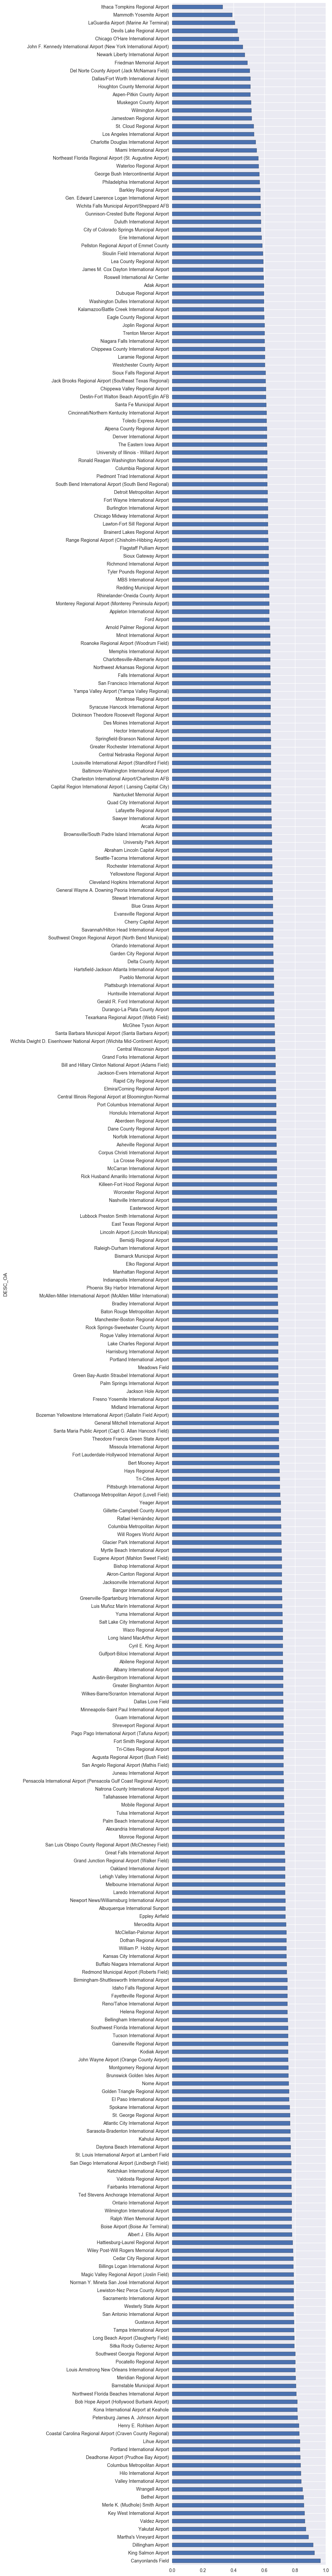

In [40]:
rank_airport['SCORE'].plot.barh(figsize = (6,100))
#plt.savefig('Flights_Fig15.png', dpi=300, bbox_inches="tight")
